# Capstone project 1: Housing prices advanced regression



In [114]:
#-----------------------------------------------------------------------------#
import pandas as pd
import numpy as np

#Load training data from csv files
df = pd.read_csv('train.csv', index_col=['Id']) 


## Data exploration and cleaning

In [115]:
#get overall information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

### Fill NA



In [116]:
#fill NA with 0

from pandas.api.types import is_string_dtype

for col in df.columns:
    if df[col].dtypes == 'object':
        df[col]=df[col].fillna('0') #fill na with 0
    else:
        df[col]=df[col].fillna(0)
        
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 no

In [117]:
#change the year to age
for col in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
    df[col] = df['YrSold'] - df[col]
#change SalePrice to fold of 1k
df['SalePrice'] = df.SalePrice / 1000



In [118]:
#Drop duplicates
df = df.drop_duplicates()
df.shape        

(1460, 80)

### Data visualization for data exploration

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

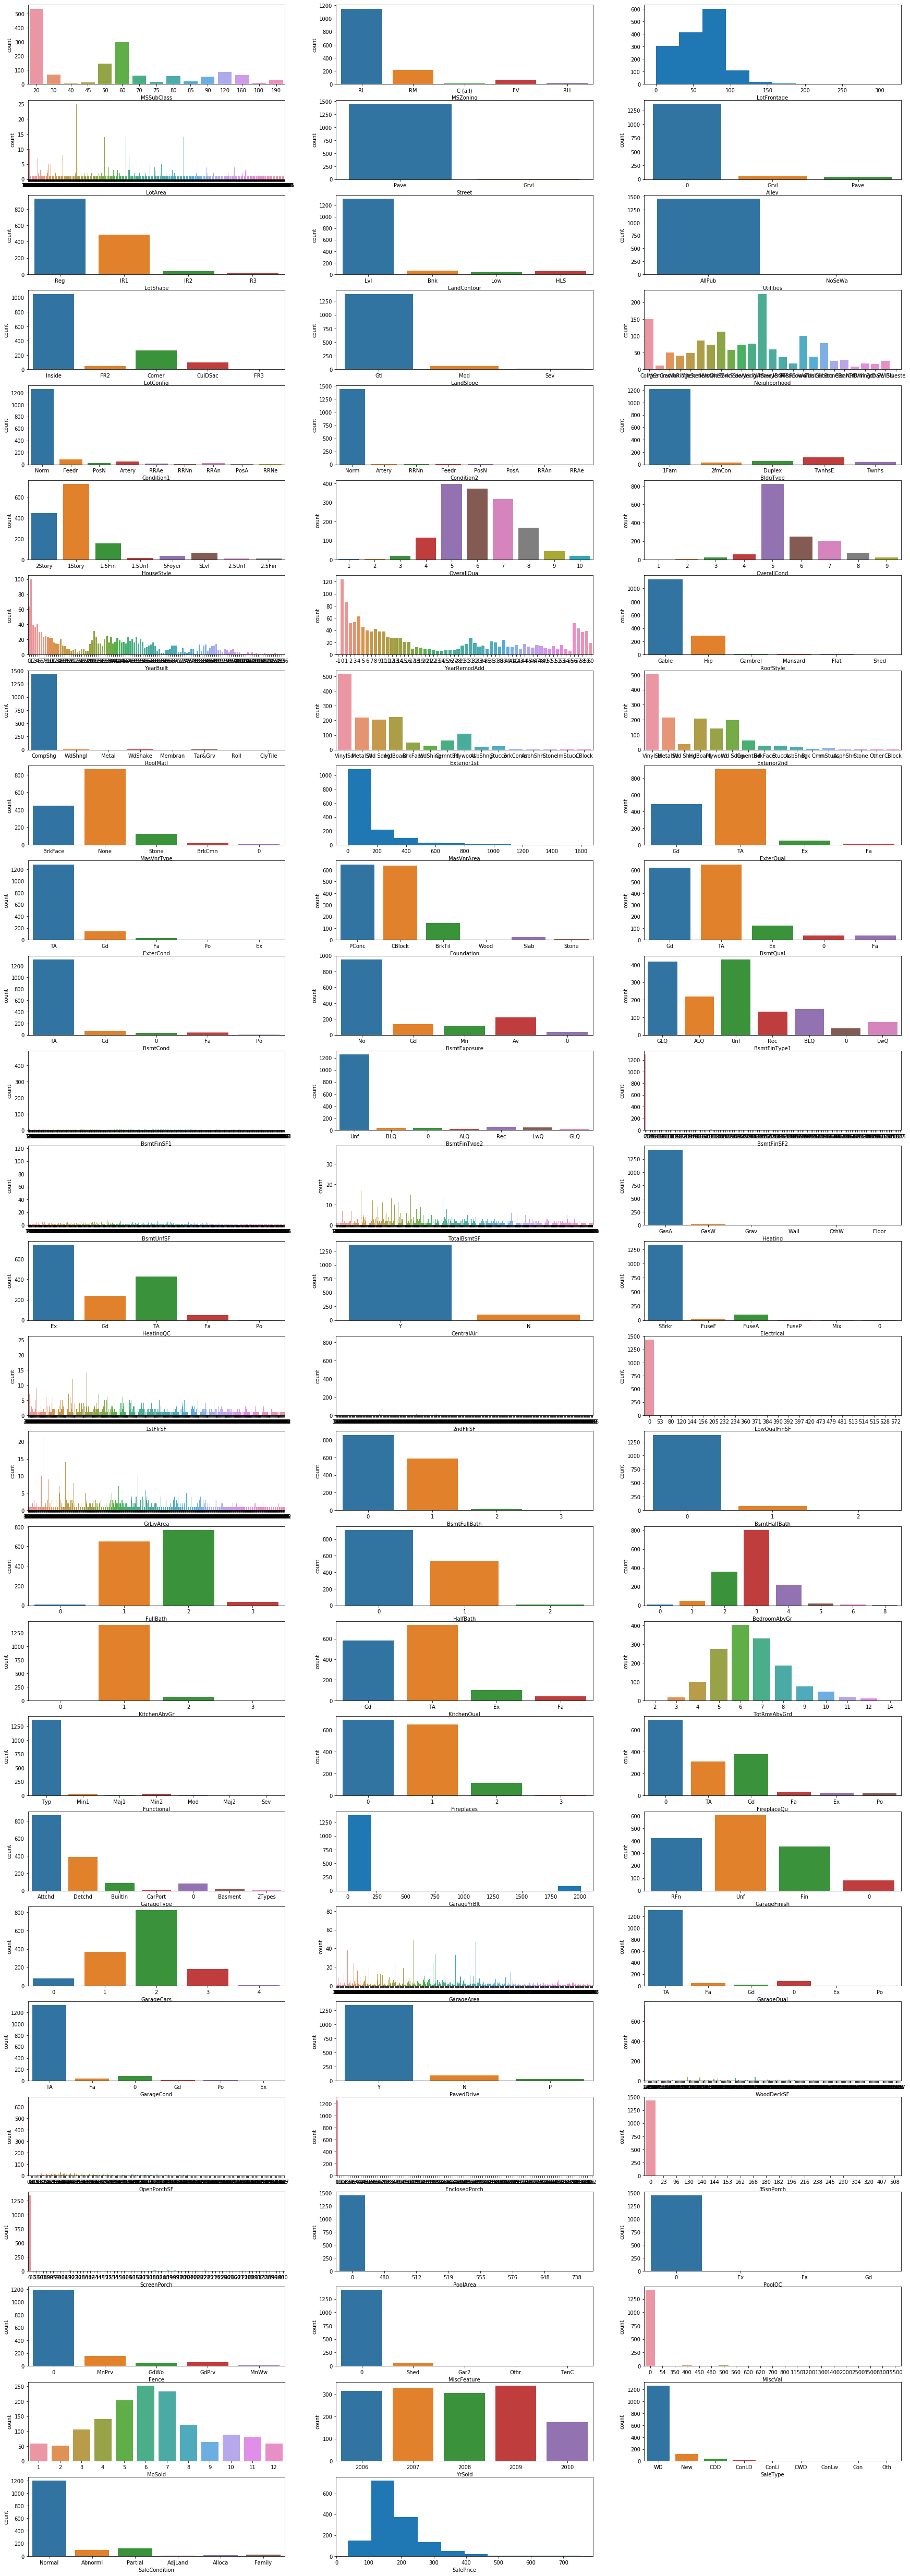

In [120]:
#Plot distribution of each column
fig1 = plt.figure(figsize=(30,90))

a = 0 #active plot number
for col in df.columns:
    a += 1
    ax = fig1.add_subplot(27,3,a)
    if df[col].dtype == 'float64':
        ax.hist(df[col], bins=10)
    else:
        sns.countplot(data=df, x=col,ax=ax)
    ax.set_xlabel(col)
       
fig1.savefig('distribution_plot.png')


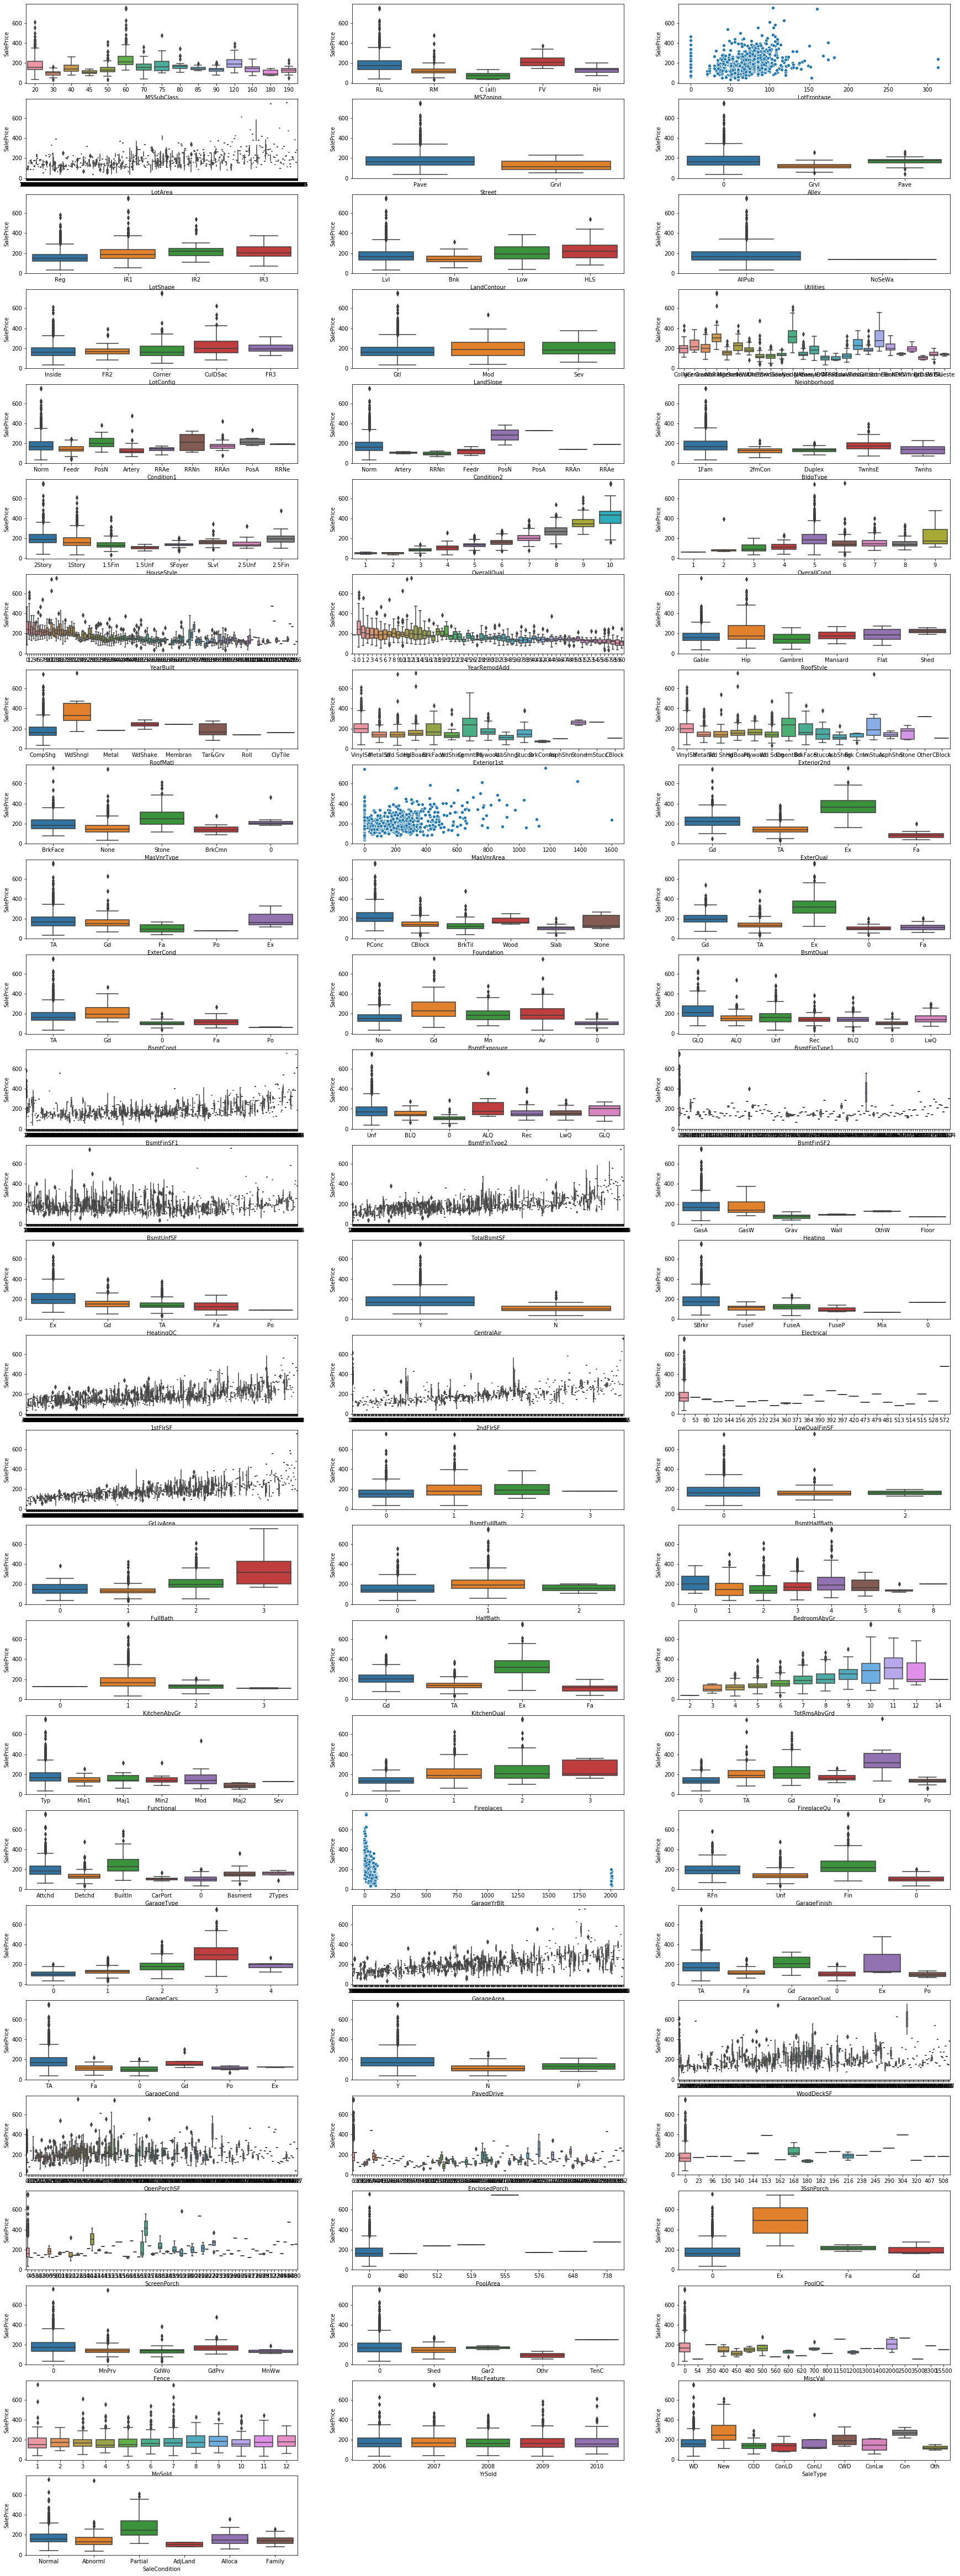

In [121]:
#plot coloumn and SalePrice relation
fig2 = plt.figure(figsize=(30,85))
y_col = df.columns[-1]
a = 0 #active plot number
for col in df.columns[:-1]:
    a += 1
    ax = fig2.add_subplot(27,3,a)
    if df[col].dtype == 'float64':
        sns.scatterplot(x=col, y=y_col, data=df,ax=ax)
    else:
        sns.catplot(x=col, y=y_col,kind='box',data=df,ax=ax)

    ax.set_xlabel(col)
    plt.close(2)
    
fig2.savefig('Correlation_plot.png')

## Modeling
### First Regression

In [122]:
#Preprocessing
#drop some columns that looks irrelevent to SalePrice according to correlation_plot
drop_1 = ['GarageYrBlt','MoSold','YrSold']

In [123]:
""" 
drop some columns that has no diverse infromation according to distribution_plot
e.g. only one column with high value, and the others don't have enough data count
""" 

drop_2 = ['Street','Alley','Utilities','Condition2','RoofMatl','Heating','LowQualFinSF',\
          'GarageCond','PavedDrive','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',\
          'PoolQC','MiscFeature','MiscVal']

In [124]:
drops = drop_1 + drop_2
df1 = df.drop(drops,axis=1)
df1.shape

(1460, 61)

In [357]:
#usig Label Encoder to deal with categorial data
from sklearn.preprocessing import LabelEncoder

X_train,y_train = df1.iloc[:,:-1],df1.iloc[:,-1]
le_train = LabelEncoder()

X_train = X_train.apply(lambda x: le_train.fit_transform(x))
X_train.shape

(1460, 60)

In [358]:
import warnings
warnings.filterwarnings('ignore')

In [360]:
# dummy data using OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

categorical_mask = (X_train.dtypes == 'object')
#categorical_columns = X.columns[categorical_mask].to_list()

ohe_train = OneHotEncoder(categorical_features=categorical_mask, sparse=False)
X_train = ohe_train.fit_transform(X_train)

X_train.shape

(1460, 60)

In [361]:
%%time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

search_grid = {
    'learning_rate':np.arange(0.05,1,0.05),
    'n_estimators':np.arange(50,300,50),
    'subsample':np.arange(0.05,1,0.05)
}
model = xgb.XGBRegressor(max_depth=8,objective='reg:squarederror')
random_search_mse = RandomizedSearchCV(estimator=model,
                                       param_distributions=search_grid,
                                       scoring='neg_mean_squared_error',
                                       cv=4,
                                       n_iter=10,
                                       verbose=1)
random_search_mse.fit(X_train,y_train)
print('Best score: ', random_search_mse.best_score_)
print('Bset model: ', random_search_mse.best_estimator_)
print('Best_RMSE: ',np.sqrt(np.abs(random_search_mse.best_score_)))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   21.0s finished


Best score:  -722.5330664903935
Bset model:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.45, verbosity=1)
Best_RMSE:  26.879975195122363
CPU times: user 22.1 s, sys: 69 ms, total: 22.2 s
Wall time: 22.3 s


In [362]:
from sklearn.metrics import r2_score
y_train_predict = random_search_mse.best_estimator_.predict(X_train)
r2_score(y_train,y_train_predict)

0.9922706892472699

In [363]:
search_grid = {
    'learning_rate':np.arange(0.05,1,0.05),
    'subsample':np.arange(0.05,1,0.05),
    'max_depth':np.arange(3,10,1)
}
model = xgb.XGBRegressor(n_estimators=250,objective='reg:squarederror')

random_search_r2 = RandomizedSearchCV(estimator=model,
                                      param_distributions=search_grid,
                                      scoring= 'r2',
                                      cv=4,
                                      n_iter=10,
                                      verbose=1)
random_search_r2.fit(X_train,y_train)
print('Best score: ', random_search_r2.best_score_)
print('Bset model: ', random_search_r2.best_estimator_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   31.3s finished


Best score:  0.8898235274824268
Bset model:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.45, verbosity=1)


In [364]:
y_train_predict_2 = random_search_r2.best_estimator_.predict(X_train)
r2_score(y_train,y_train_predict_2)

0.9845846971246609

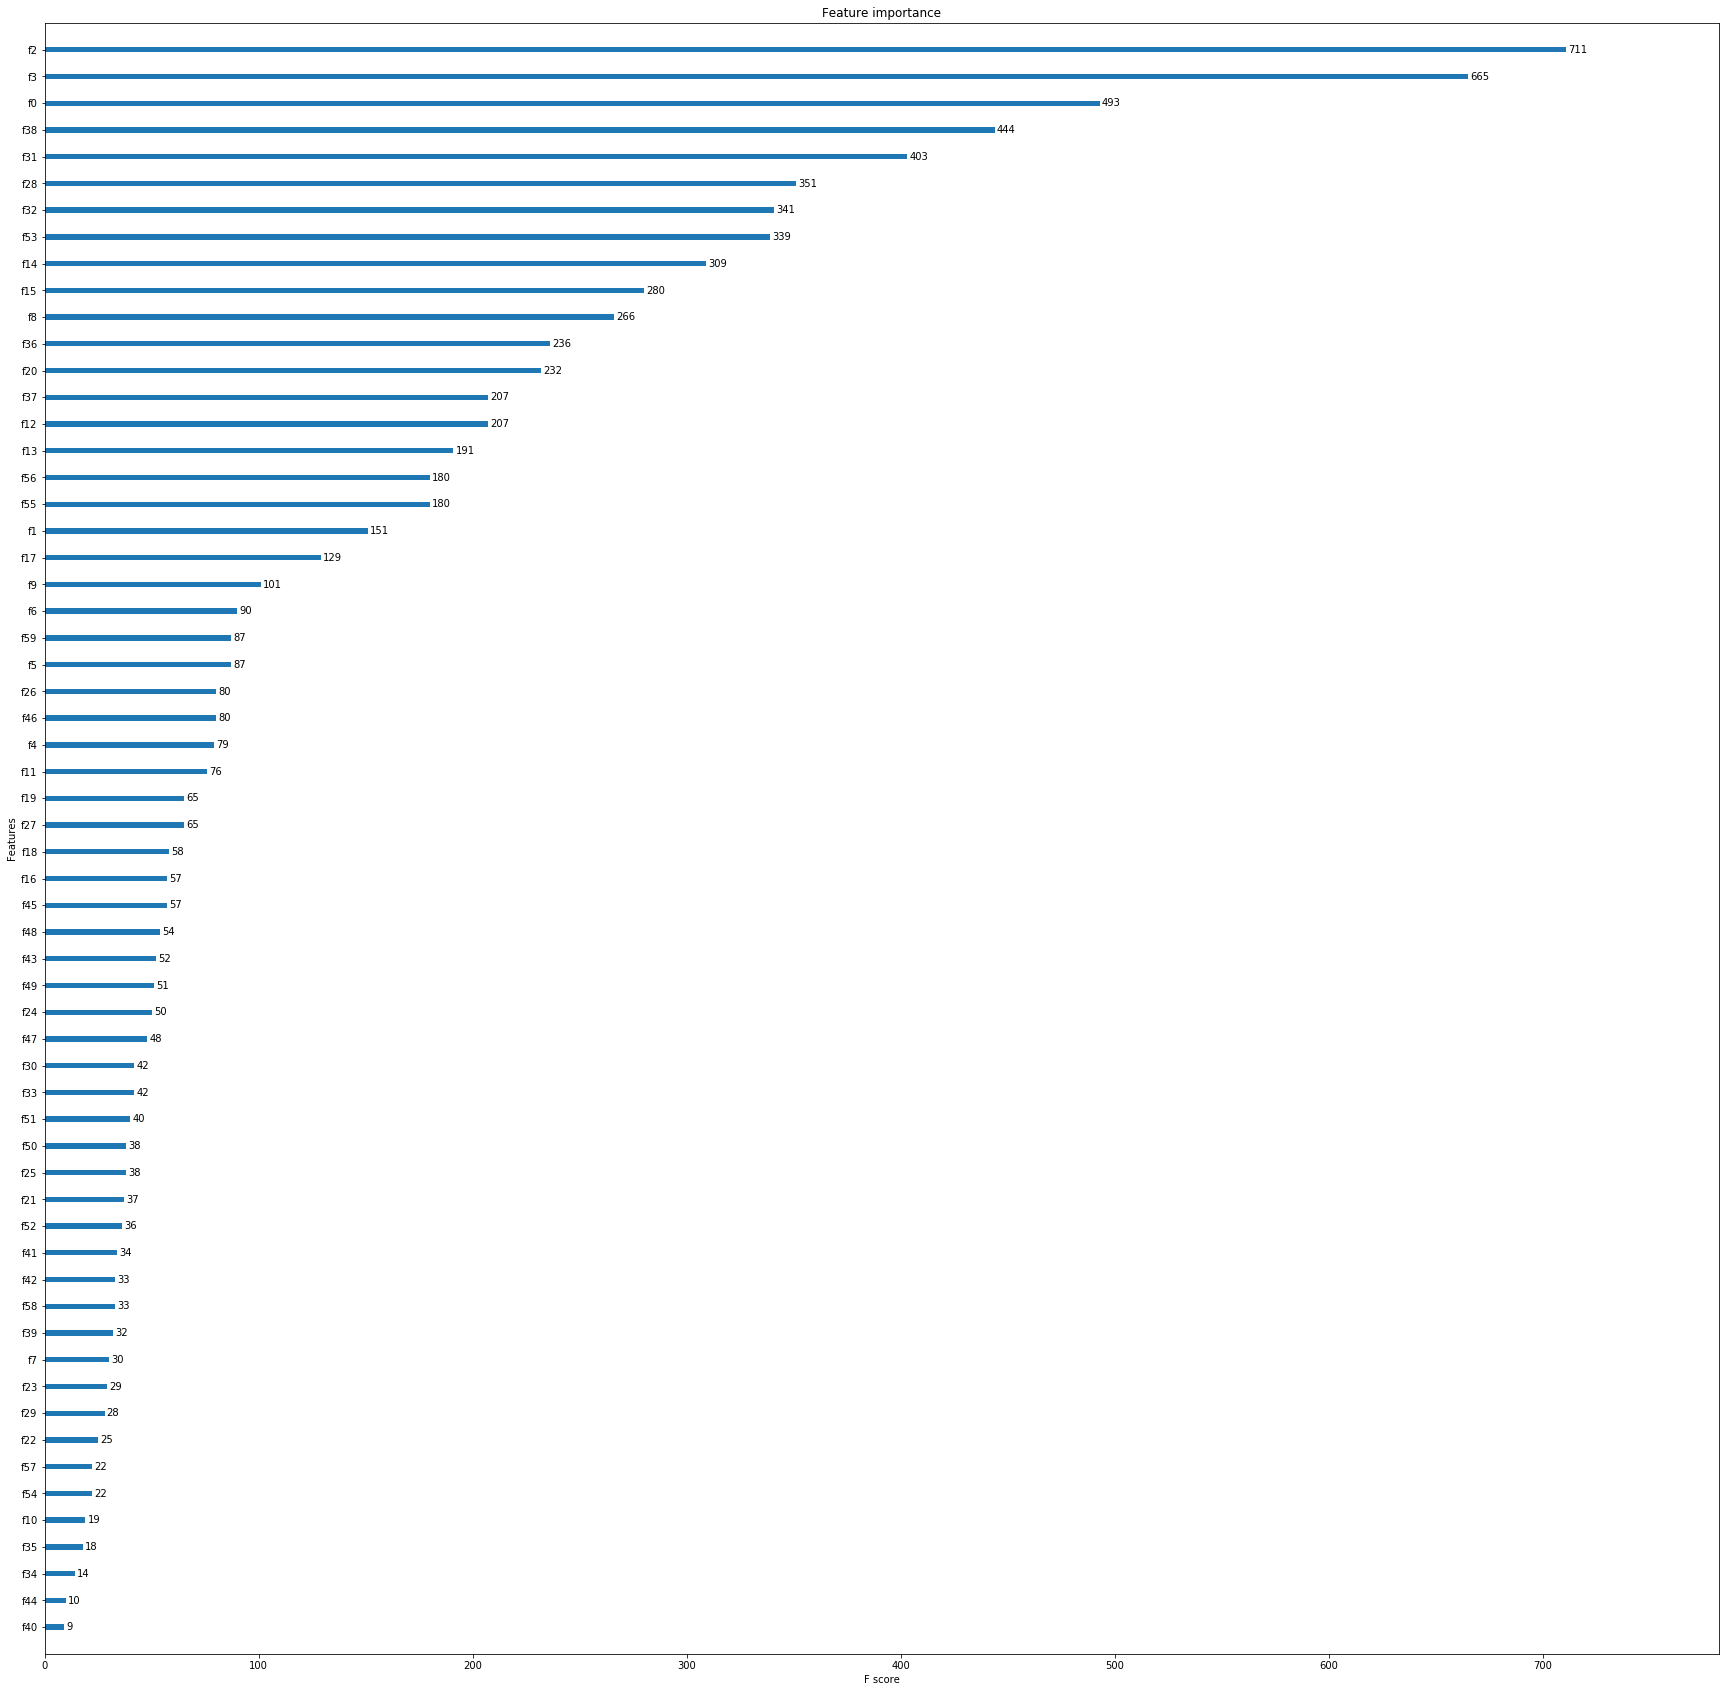

In [378]:
# plot importance 
from xgboost import plot_importance
fig3, ax3 = plt.subplots(1,1,figsize=(30,30))

plot_importance(random_search_mse.best_estimator_,ax=ax3,grid=False)
plt.show()

### Predict Testing data

In [384]:
#Load test data
df_test = pd.read_csv('test.csv', index_col=['Id']) 

In [385]:
df.shape,df_test.shape

((1460, 80), (1459, 79))

In [386]:
#Fill NA
for col in df_test.columns:
    if df_test[col].dtypes == 'object':
        df_test[col]=df_test[col].fillna('0') #fill na with 0
    else:
        df_test[col]=df_test[col].fillna(0)
df_test.shape

(1459, 79)

In [387]:
#Drop duplicates
df_test = df_test.drop_duplicates()
df_test.shape     

(1459, 79)

In [388]:
#Drop unnecessary columns
df_test = df_test.drop(drops,axis=1)
df_test.shape

(1459, 60)

In [393]:
#convert catergorical data using LabelEncoder and OneHotEncoder

le_test = LabelEncoder()
ohe_test = OneHotEncoder(categorical_features=categorical_mask, sparse=False)

X_test = df_test.apply(lambda x: le_test.fit_transform(x))
X_test = ohe_test.fit_transform(X_test)


In [394]:
X_test.shape

(1459, 60)

In [400]:
#predict using random_search_r2 best model
y_predict_1 = random_search_r2.best_estimator_.predict(X_test)


In [401]:
#predict using random_search_mse best model
y_predict_2 = random_search_mse.best_estimator_.predict(X_test)

In [405]:
#Two predicts is very similar
r2_score(y_predict_1,y_predict_2)

0.978733964894424

In [409]:
#Negative control: when compare the y value in train data with predicted y data, there is no correlation.
r2_score(y_train[0:1458],y_predict_2[0:1458])

-0.8110366728959157